In [3]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import sys

sys.path.append('../')

# from algorithms.sequence_models.old_decision_transformer.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.evaluate import evaluate_on_env
from data.random_walk_dataset import RandomWalkDataset
from envs.random_walk import RandomWalkEnv
from data.trajectory import LimitedContextWrapper
from algorithms.sequence_models.config import TrainConfig
from algorithms.sequence_models.trainer import Trainer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

pygame 2.5.2 (SDL 2.28.2, Python 3.10.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


2024-05-08 08:25:31.505639: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 08:25:31.532493: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 08:25:32.249747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


device(type='cuda')

In [29]:
class CustomCallback:
	def __init__(self, env, model, optimizer, logger, device, traj_dataset, config, rtgs=[]):
		self.env = env
		self.model = model
		self.optimizer = optimizer
		self.logger = logger
		self.device = device
		self.traj_dataset = traj_dataset
		self.config = config
		self.rtgs = rtgs
		self.eval_results = []
		
	def callback(self, df, **kwargs):
		results = evaluate_on_env(
			model=self.model, traj_dataset=self.traj_dataset,
			device=self.device, context_len=self.config.context_len,
			env=self.env, rtg_target=self.config.rtg_main,
			num_eval_ep=self.config.num_eval_ep,
			max_test_ep_len=self.config.max_eval_ep_len)
		self.logger.log(
				   model=self.model,
				   loss=df['train/loss'].sum(),
				   eval_avg_reward=results['eval/avg_reward'],
				   eval_avg_ep_len=results['eval/avg_ep_len'],
				   grad_norm=max(torch.norm(param.grad) for param in self.model.parameters() if param.grad is not None),
				   lr=self.optimizer.param_groups[0]['lr'],
				   important={"grad_norm", "lr"})
		res = {}
		for rtg in self.rtgs:
			res[rtg] = evaluate_on_env(
				model=self.model,
				traj_dataset=self.traj_dataset,
				device=self.device,
				context_len=self.config.context_len,
				env=self.env,
				rtg_target=rtg,
				num_eval_ep=self.config.num_eval_ep
			)
		self.eval_results.append(res)
	
	def plot_eval_results(self):
		plt.figure()
		for rtg in self.rtgs:
			plt.plot([res[rtg]['eval/avg_reward'] for res in self.eval_results])
		plt.xlabel('iteration')
		plt.ylabel('avg_reward')
		plt.legend([f'r={rtg:.2f}' for rtg in self.rtgs])

		plt.figure()
		
		for rtg in self.rtgs:
			n = len(self.eval_results)
			plt.plot(range(n//2, n), [res[rtg]['eval/avg_ep_len'] for res in self.eval_results[n//2:]])
			
		plt.xlabel('iteration')
		plt.ylabel('avg_reward')
		plt.legend([f'r={rtg:.2f}' for rtg in self.rtgs])

Dataset Info:
episode_max_length: 20
reward_scale: 20
return min=-160, max=9 mean=-31.926315789473684
state_mean: [0.20570175 0.10153509 0.10482456 0.09714912 0.10197368 0.09824561
 0.10087719 0.09342105 0.09627193 0.        ]
state_std: [0.40421349 0.30203595 0.30632723 0.29616072 0.3026137  0.29764646
 0.30116604 0.29102158 0.2949638  0.        ]
gamma: 1
number of parameters 1125141


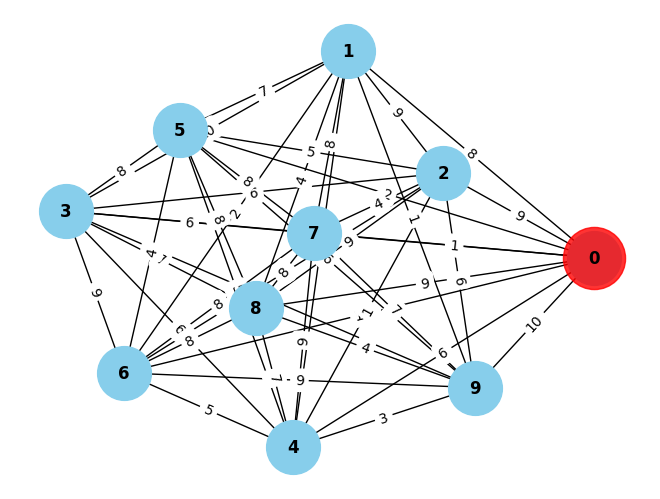

In [25]:
env = RandomWalkEnv(num_nodes=10, weight_max=10, reach_the_goal_reward=10, max_episode_length=20)
config = TrainConfig(max_eval_ep_len=20, context_len=25, rtg_range_check=(-10, 10), rtg_main=5)
traj_dataset = RandomWalkDataset(env, n_trajectories=500, reward_scale=20)

env.reset()
env.render()

model = DecisionTransformer(
			state_dim=traj_dataset.state_dim(),
			act_dim=traj_dataset.action_dim(),
			n_blocks=config.n_blocks,
			h_dim=config.embed_dim,
			context_len=config.context_len,
			n_heads=config.n_heads,
			drop_p=config.dropout_p,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.wt_decay)

scheduler = torch.optim.lr_scheduler.LambdaLR(
	optimizer,
	lambda steps: min((steps+1)/config.warmup_steps, 1)
)

loss_fn = nn.MSELoss(reduction='mean')

trainer = Trainer(name='random-walk-another', model=model,
				  optimizer=optimizer, loss_fn=loss_fn,
				  dataset=LimitedContextWrapper(traj_dataset, context_len=config.context_len),
				  device=device, config=config, scheduler=scheduler)

callback = CustomCallback(env=env, model=model,
						  optimizer=optimizer, logger=trainer.logger, device=device, traj_dataset=traj_dataset, config=config,
						  rtgs=np.linspace(config.rtg_range_check[0], config.rtg_range_check[1], 5))

trainer.register_callback(callback.callback)

print("number of parameters", sum(np.prod(param.shape) for param in model.parameters()))

In [27]:
report = trainer.train()

  0%|          | 0/200 [00:00<?, ?it/s]

achieved average reward:  0.0
saving max score model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-another_model_24-05-08-08-47-07_best.pt
saving current model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-another_model_24-05-08-08-47-07.pt
time elapsed: 0:00:01
num of updates: 100
loss: 8.39483
eval avg reward: 0.00000
best score: -inf
eval_avg_ep_len 1.00000
grad_norm 0.08176
lr 0.00012
achieved average reward:  0.0
saving max score model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-another_model_24-05-08-08-47-07_best.pt
saving current model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-another_model_24-05-08-08-47-07.pt
time elapsed: 0:00:02
num of updates: 200
loss: 8.32093
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 1.00000
grad_norm 0.08649
lr 0.00013
achieved average reward:  0.0
saving max score model 

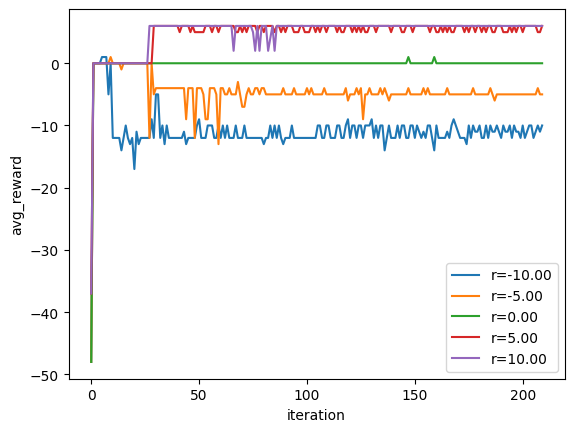

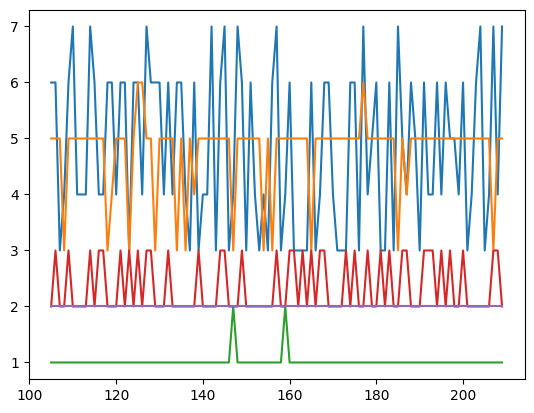

In [28]:
callback.plot_eval_results()

<Axes: >

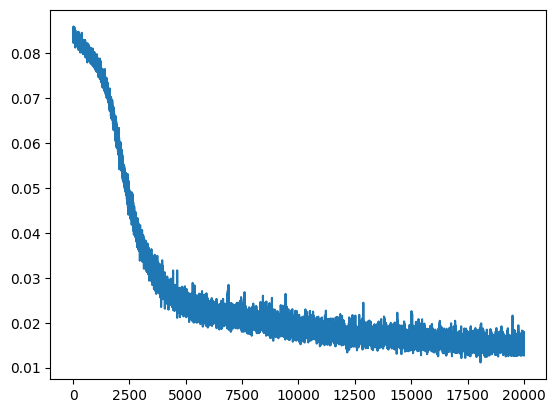

In [48]:
report.sort_values(by=['train/iteration', 'train/update_idx']).reset_index()['train/loss'].plot()